In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

# Copy thư mục từ Google Drive sang local Colab
src_path = '/content/drive/MyDrive/Extracted_MRI'
dst_path = '/content/Extracted_MRI'

shutil.copytree(src_path, dst_path)

print("✅ Đã sao chép thư mục về local Colab.")


✅ Đã sao chép thư mục về local Colab.


In [ ]:
# Install necessary libraries
!pip install ultralytics
!pip install plotly
!pip install opencv-python-headless

import os
import cv2
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import yaml

In [ ]:
pip install wandb

In [ ]:
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nguyentheanh02702 (nguyentheanh02702-hanoi-university-of-science-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:

# Paths to data directories
train_path = "/content/Extracted_MRI/Train"
val_path = "/content/Extracted_MRI/Val"

In [ ]:
# Classes
classes = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]


In [ ]:
# Function to load images and labels
def load_data(data_path):
    images = []
    labels = []
    for class_label in classes:
        class_path = os.path.join(data_path, class_label, 'images')
        label_path = os.path.join(data_path, class_label, 'labels')
        for img_file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label_file = img_file.replace('.jpg', '.txt')
            label_file_path = os.path.join(label_path, label_file)
            if os.path.exists(label_file_path):
                with open(label_file_path, 'r') as file:
                    label_data = file.readline().strip().split()
                    if len(label_data) > 0:
                        images.append(img)
                        labels.append(label_data)
                    else:
                        print(f"Label file {label_file_path} is empty, skipping this image.")
            else:
                print(f"Label file {label_file_path} not found, skipping this image.")
    return images, labels

# Load training and validation data
train_images, train_labels = load_data(train_path)
val_images, val_labels = load_data(val_path)

Label file /content/Extracted_MRI/Val/Glioma/labels/gg (342).txt is empty, skipping this image.
Label file /content/Extracted_MRI/Val/No Tumor/labels/image(61).txt not found, skipping this image.
Label file /content/Extracted_MRI/Val/No Tumor/labels/image(55).txt not found, skipping this image.


In [ ]:
# EDA - Visualize class distribution
train_counts = [len(os.listdir(os.path.join(train_path, cls, 'images'))) for cls in classes]
val_counts = [len(os.listdir(os.path.join(val_path, cls, 'images'))) for cls in classes]
eda_df = pd.DataFrame({'Class': classes, 'Train': train_counts, 'Validation': val_counts})

fig = go.Figure(data=[
    go.Bar(name='Train', x=eda_df['Class'], y=eda_df['Train']),
    go.Bar(name='Validation', x=eda_df['Class'], y=eda_df['Validation'])
])
fig.update_layout(barmode='group', title='Class Distribution in Training and Validation Sets')
fig.show()

In [ ]:
# Image Preprocessing
def preprocess_images(images):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, (640, 640))
        processed_images.append(img_resized)
    return np.array(processed_images)

train_images = preprocess_images(train_images)
val_images = preprocess_images(val_images)

In [ ]:
dataset_yaml = {
    'path': '/content/Extracted_MRI',  # Đường dẫn gốc chứa Train và Val
    'train': 'Train',  # hoặc 'images/train' tùy cấu trúc
    'val': 'Val',      # hoặc 'images/val'
    'names': classes
}

# Ghi ra file YAML
with open('/content/drive/MyDrive/Extracted_MRI/dataset.yaml', 'w') as file:
    yaml.dump(dataset_yaml, file)

print("Đã tạo file dataset.yaml thành công.")

Đã tạo file dataset.yaml thành công.


In [ ]:
# YOLOv8 Model Training
yolo_model = YOLO("yolov8s.pt")  # Load a pre-trained YOLOv8 model
train_results = yolo_model.train(data='/content/drive/MyDrive/Extracted_MRI/dataset.yaml', epochs=30, imgsz=640)

100%|██████████| 21.5M/21.5M [00:00<00:00, 191MB/s]


Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Extracted_MRI/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 

100%|██████████| 755k/755k [00:00<00:00, 34.5MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

Model summary: 129 layers, 11,137,148 parameters, 11,137,132 gradients, 28.7 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 143MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1357.0±342.7 MB/s, size: 37.3 KB)


train: Scanning /content/Extracted_MRI/Train/Glioma/labels... 4737 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4737/4737 [00:03<00:00, 1454.04it/s]


train: New cache created: /content/Extracted_MRI/Train/Glioma/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 352.7±193.3 MB/s, size: 26.3 KB)


val: Scanning /content/Extracted_MRI/Val/Glioma/labels... 510 images, 3 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:00<00:00, 1173.99it/s]

val: New cache created: /content/Extracted_MRI/Val/Glioma/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.74G      1.053      1.828      1.256          1        640: 100%|██████████| 297/297 [01:14<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]

                   all        512        554      0.729      0.632      0.712       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.53G      1.045      1.087      1.233          1        640: 100%|██████████| 297/297 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.87it/s]

                   all        512        554      0.817       0.75      0.834      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.55G      1.057      1.015      1.234          2        640: 100%|██████████| 297/297 [01:12<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.84it/s]

                   all        512        554      0.795      0.737      0.812      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.61G      1.018     0.9439        1.2          0        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.88it/s]

                   all        512        554      0.868      0.834      0.918      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.64G     0.9839     0.8489      1.182          2        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.85it/s]

                   all        512        554      0.877       0.83      0.905      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.68G     0.9497     0.7795      1.162          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]

                   all        512        554      0.892      0.839      0.916      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       4.7G     0.9205      0.747      1.143          3        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.84it/s]

                   all        512        554      0.895      0.868      0.927      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.75G     0.9112     0.7098      1.139          2        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]

                   all        512        554      0.906      0.887      0.942      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.79G     0.8918     0.6843      1.124          0        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.95it/s]

                   all        512        554      0.926      0.875      0.938      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.82G     0.8958     0.6771      1.127          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.94it/s]

                   all        512        554      0.902       0.89      0.937       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.85G     0.8646     0.6503      1.118          2        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.85it/s]

                   all        512        554      0.919      0.894       0.94      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       4.9G     0.8528     0.6207      1.106          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.87it/s]

                   all        512        554      0.927      0.911      0.958      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.93G     0.8506     0.6154      1.111          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]

                   all        512        554      0.904      0.903      0.947      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.97G     0.8265     0.5884      1.096          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.94it/s]

                   all        512        554      0.929      0.909      0.963      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.99G     0.8243     0.5587      1.094          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]

                   all        512        554      0.926      0.915      0.958      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.04G     0.8098     0.5547       1.08          0        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]

                   all        512        554      0.928      0.904      0.962       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.08G     0.8111     0.5511      1.078          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]

                   all        512        554      0.935      0.909      0.955      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.11G      0.787     0.5257      1.068          0        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]

                   all        512        554      0.941      0.928       0.96      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.13G     0.7764     0.5078      1.067          3        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]

                   all        512        554      0.953      0.924      0.961      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.19G     0.7793     0.5026      1.067          3        640: 100%|██████████| 297/297 [01:12<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.84it/s]

                   all        512        554      0.951      0.927      0.961      0.778


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.22G     0.7304     0.4609      1.042          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]

                   all        512        554       0.94      0.904      0.953      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.26G     0.7208     0.4498      1.033          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]

                   all        512        554      0.926      0.937      0.959      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.28G      0.703     0.4169       1.02          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]

                   all        512        554      0.949      0.927      0.958      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.33G     0.6996     0.4041      1.018          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]

                   all        512        554      0.961      0.923      0.963      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.37G     0.6798       0.39       1.01          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.84it/s]

                   all        512        554      0.943      0.941      0.963      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       5.4G     0.6716     0.3748      1.003          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.95it/s]

                   all        512        554      0.957      0.926      0.966      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.43G     0.6621     0.3603     0.9946          2        640: 100%|██████████| 297/297 [01:12<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.83it/s]

                   all        512        554      0.962      0.929      0.965      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.48G     0.6489     0.3469     0.9934          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]

                   all        512        554      0.955      0.935      0.964      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.51G     0.6347     0.3393     0.9815          1        640: 100%|██████████| 297/297 [01:12<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.88it/s]

                   all        512        554      0.949      0.943      0.965      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.55G     0.6324      0.333     0.9807          2        640: 100%|██████████| 297/297 [01:12<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]

                   all        512        554      0.947      0.944      0.965      0.806



30 epochs completed in 0.643 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]


                   all        512        554      0.949      0.943      0.965      0.809
                Glioma        135        153      0.916      0.895      0.933      0.778
            Meningioma        140        142      0.978          1      0.993      0.842
              No Tumor         98         98      0.978       0.99      0.989      0.857
             Pituitary        154        161      0.924      0.888      0.945       0.76
Speed: 0.2ms preprocess, 4.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


In [ ]:
# Save the YOLOv8 model
yolo_model.save('/content/drive/MyDrive/Extracted_MRI/yolov8_model.pt')

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=your_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, p

RuntimeError: Dataset 'your_dataset.yaml' error ❌ 'your_dataset.yaml' does not exist


0: 640x640 1 Glioma, 16.3ms
Speed: 3.6ms preprocess, 16.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


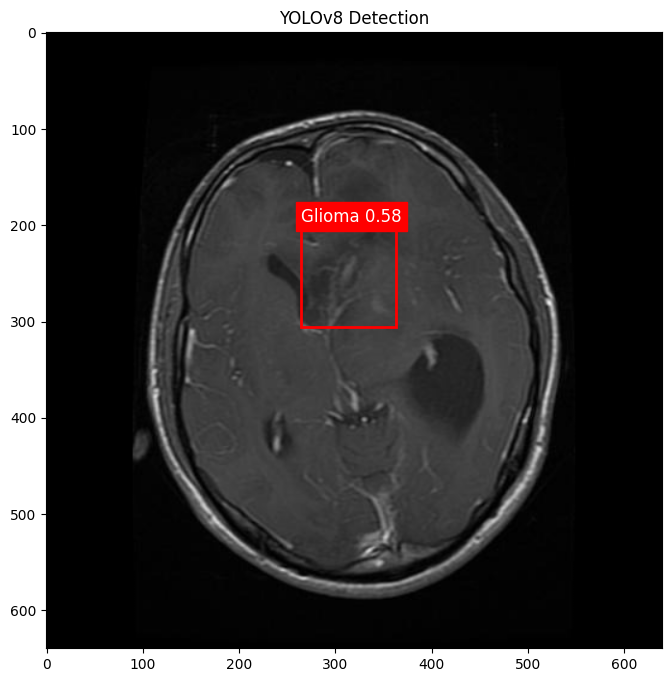


0: 640x640 1 Glioma, 16.5ms
Speed: 3.0ms preprocess, 16.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


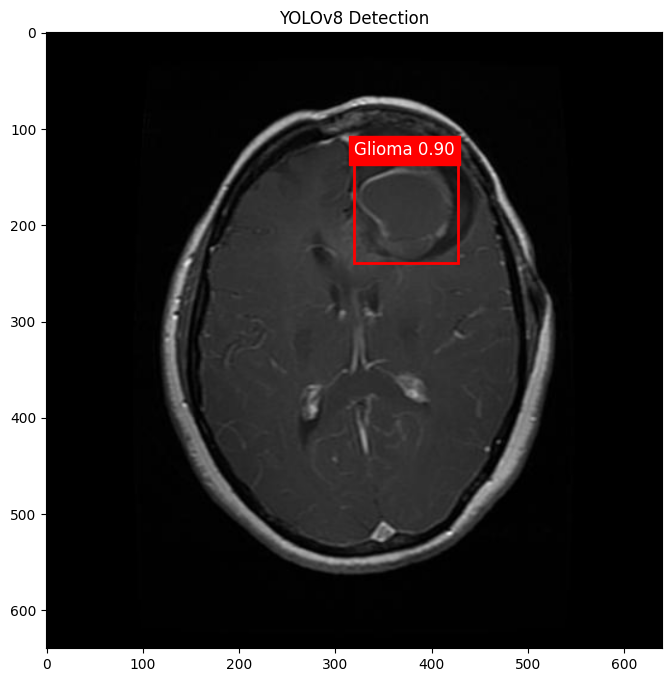


0: 640x640 1 Glioma, 16.4ms
Speed: 2.7ms preprocess, 16.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


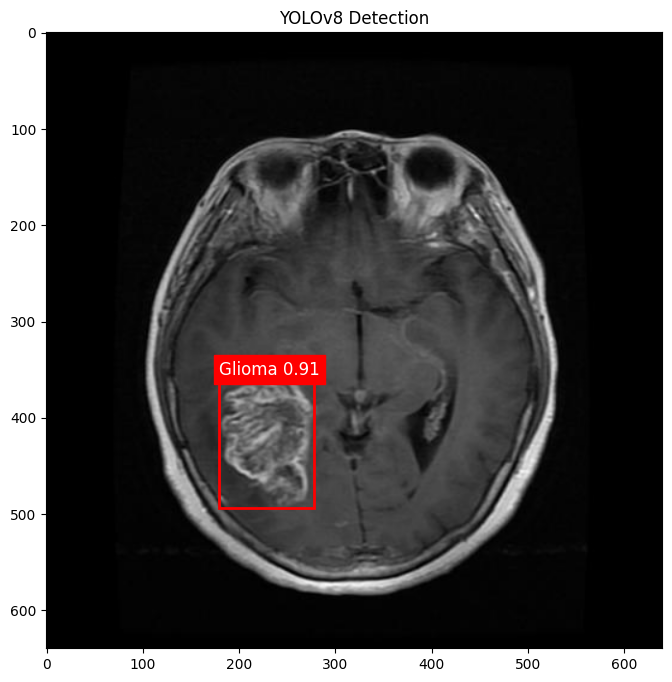


0: 640x640 1 Glioma, 16.5ms
Speed: 2.8ms preprocess, 16.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


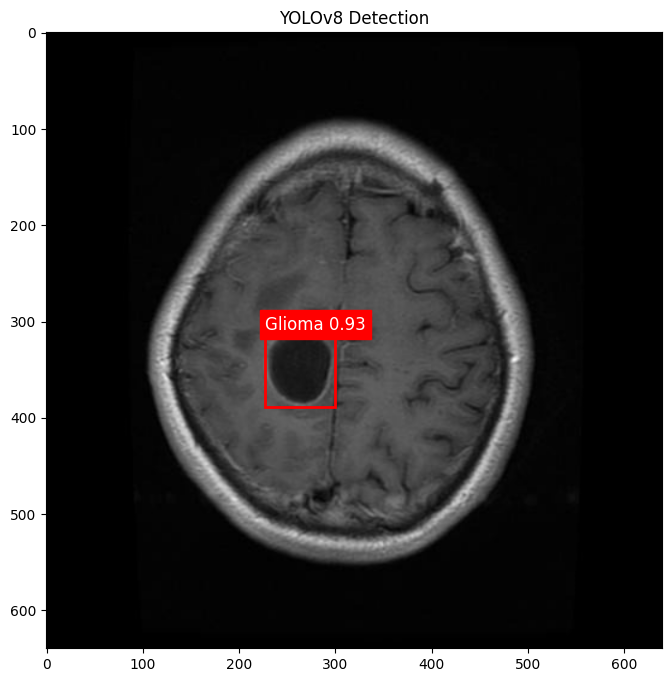


0: 640x640 1 Glioma, 16.5ms
Speed: 3.2ms preprocess, 16.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


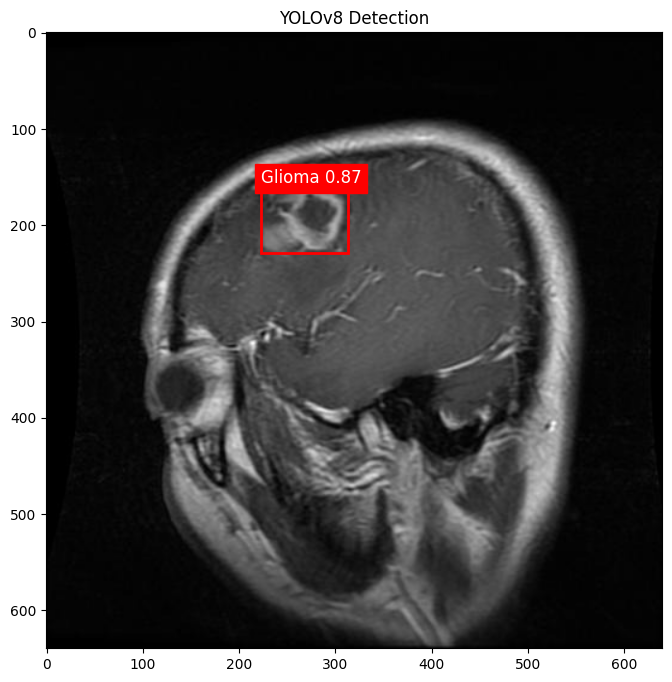


0: 640x640 1 Glioma, 16.4ms
Speed: 3.4ms preprocess, 16.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


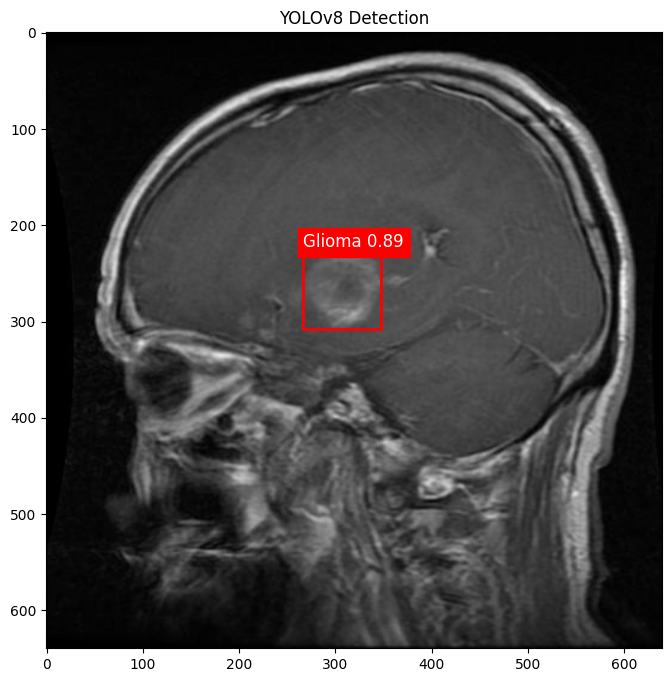


0: 640x640 4 Gliomas, 16.4ms
Speed: 3.4ms preprocess, 16.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


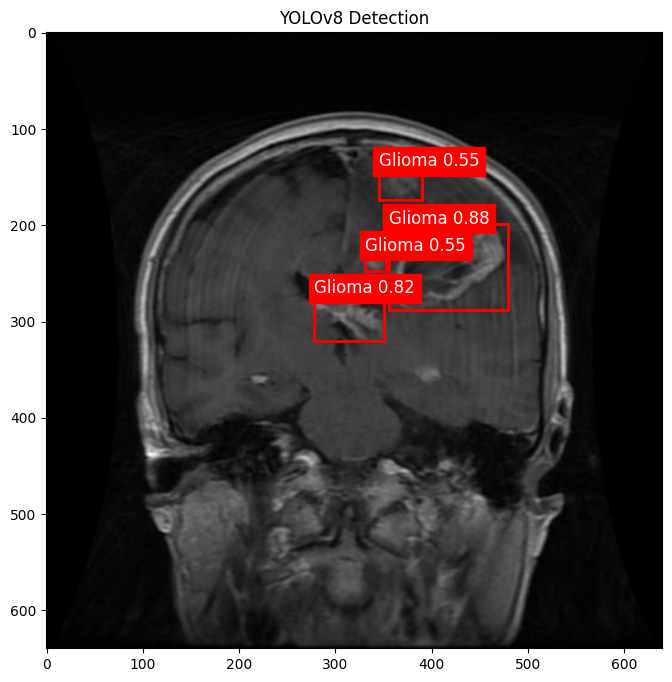


0: 640x640 1 Glioma, 16.4ms
Speed: 2.5ms preprocess, 16.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


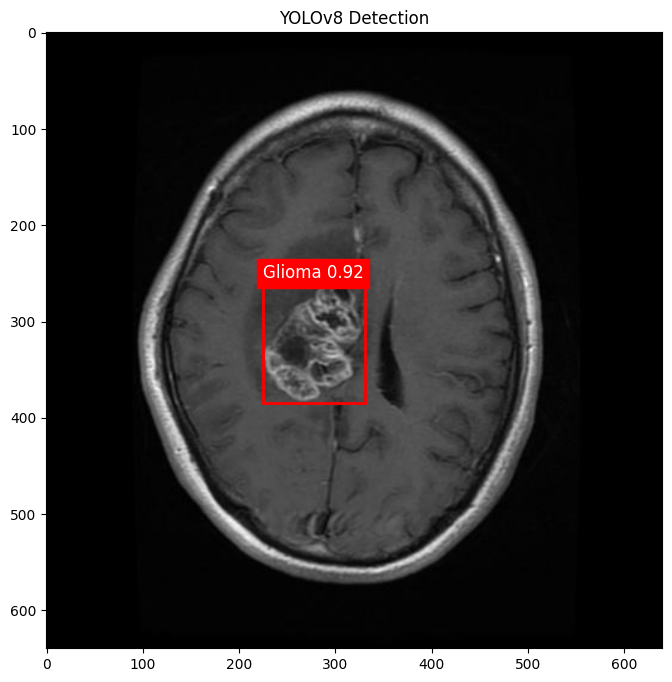


0: 640x640 1 Meningioma, 16.4ms
Speed: 2.8ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


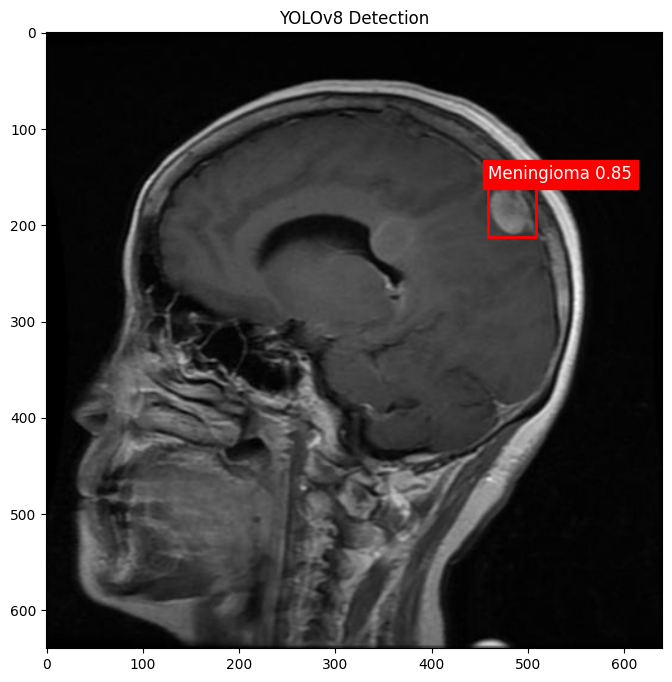


0: 640x640 1 Glioma, 16.4ms
Speed: 2.5ms preprocess, 16.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


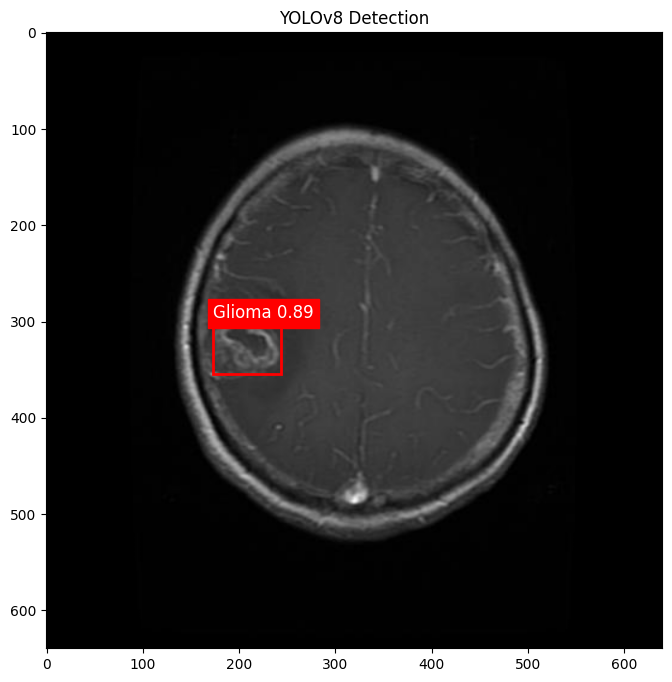

In [ ]:
# Function to display detection results with highlighted parts
def display_samples(images, yolo_model):
    for i in range(10):
        img = images[i]
        result = yolo_model.predict(img)[0]  # Assuming batch size of 1, take the first result

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        ax = plt.gca()

        for detection in result.boxes:
            x1, y1, x2, y2 = detection.xyxy[0].cpu().numpy()
            conf = detection.conf[0].cpu().numpy()
            cls = detection.cls[0].cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1, f"{classes[int(cls)]} {conf:.2f}", color='white', fontsize=12, backgroundcolor='red')

        plt.title(f'YOLOv8 Detection')
        plt.show()

display_samples(val_images, yolo_model)